In [59]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [60]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [61]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

In [62]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [63]:
# Convolutional neural network (two convolutional layers)
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU())
        
        self.code = nn.Linear(128, 10)
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU())
        
        self.out = nn.Sequential(
            nn.Linear(512, input_size),
            nn.Sigmoid())
        
    def forward(self, x):
        out = self.encoder(x)
        out_code = self.code(out)
        out = self.decoder(out_code)
        out = self.out(out)
        return out, out_code

In [64]:
model = AutoEncoder(784).to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (code): Linear(in_features=128, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [65]:
# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        #print(i, images.shape)
        #labels = labels.to(device)
        
        # Forward pass
        outputs, code_outputs = model(images)
        loss = loss_func(outputs, images)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.0604
Epoch [1/5], Step [200/600], Loss: 0.0381
Epoch [1/5], Step [300/600], Loss: 0.0282
Epoch [1/5], Step [400/600], Loss: 0.0297
Epoch [1/5], Step [500/600], Loss: 0.0242
Epoch [1/5], Step [600/600], Loss: 0.0224
Epoch [2/5], Step [100/600], Loss: 0.0202
Epoch [2/5], Step [200/600], Loss: 0.0213
Epoch [2/5], Step [300/600], Loss: 0.0204
Epoch [2/5], Step [400/600], Loss: 0.0208
Epoch [2/5], Step [500/600], Loss: 0.0194
Epoch [2/5], Step [600/600], Loss: 0.0211
Epoch [3/5], Step [100/600], Loss: 0.0207
Epoch [3/5], Step [200/600], Loss: 0.0176
Epoch [3/5], Step [300/600], Loss: 0.0163
Epoch [3/5], Step [400/600], Loss: 0.0169
Epoch [3/5], Step [500/600], Loss: 0.0197
Epoch [3/5], Step [600/600], Loss: 0.0169
Epoch [4/5], Step [100/600], Loss: 0.0169
Epoch [4/5], Step [200/600], Loss: 0.0174
Epoch [4/5], Step [300/600], Loss: 0.0168
Epoch [4/5], Step [400/600], Loss: 0.0175
Epoch [4/5], Step [500/600], Loss: 0.0159
Epoch [4/5], Step [600/600], Loss:

In [67]:
outputs.shape, code_outputs.shape

(torch.Size([100, 784]), torch.Size([100, 10]))

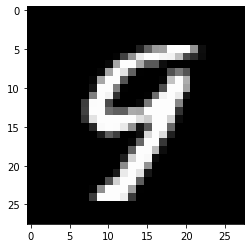

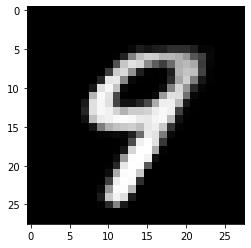

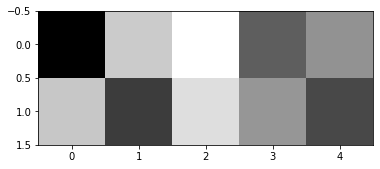

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = 1
# plot the sample
fig = plt.figure
plt.imshow(images[idx].numpy().reshape(28,28), cmap='gray')
plt.show()
plt.imshow(outputs[idx].numpy().reshape(28,28), cmap='gray')
plt.show()
plt.imshow(code_outputs[idx].numpy().reshape(2,5), cmap='gray')
plt.show()

In [72]:
code_outputs[idx]

tensor([-9.1971,  4.8737,  8.4614, -2.6528,  0.8931,  4.5514, -5.0012,  6.1786,
         1.2066, -4.2239])

In [69]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images2 = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs, code_outputs = model(images2)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 0.0 %
